# Comparison of dNBR for three wild fires in 2018 and 2019

This notebook contains the calculations necessary for mapping the burn severity of the previously selected products.
This burn severity is measured as the ${\Delta}NBR$, which is defined as:

$$
{\Delta}NBR = NBR_\text{pre-fire} - NBR_\text{post-fire}
$$

Instead of only calculating values by overlaying different bands in one product, the ${\Delta}NBR$ adds a time dimension to determine changes that have occured in the time span between the two chosen products.

## Methodology

The $NBR$ of the products downloaded in the previous notebook is calculated using the notebook **TODO**.
These $NBR$ values are plotted side-by-side to get a visual impression of the changes that may have occured between two given dates.
The ${\Delta}NBR$ is calculated and, if showing signs of burned areas, compared to data given by the responsible German ministries.

## Calculcations
### Setup

In [1]:
from pathlib import Path
import geopandas as gpd

from sentinel_helpers import geodataframe_on_map, scihub_band_paths
nbr_path = Path('output/spectral_indices/')
product_path = Path('input/forest_fires/')

### Treuenbrietzen (Postdam-Mittelmark) 2018

The first case is the wild fire in August 2018 that led to the evacuation of three villages (source).
We load the pre-calculated NBR values and geometries we fetched from OpenStreetMap:

In [2]:
potsdam_mittelmark_nbr_2018 = list(sorted(nbr_path.glob('*2018*NBR*.tif')))
potsdam_mittelmark_nbr_2018

[PosixPath('output/spectral_indices/T33UUT_20180807T101021_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20180822T101019_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20180919T102021_NBR_10m.tif')]

The `postdam_mittelmark_geom` is a collection of three points:

In [3]:
potsdam_mittelmark_geom = gpd.read_file(product_path / 'evacuated_2018.json')
# geodataframe_on_map(postdam_mittelmark_geom)
potsdam_mittelmark_geom

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,3285415,node,387079362,"Frohnsdorf, Treuenbrietzen, Potsdam-Mittelmark...",19,place,village,0.495,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (12.90217 52.05466)
1,554316,node,226935349,"Klausdorf, Treuenbrietzen, Potsdam-Mittelmark,...",19,place,village,0.495,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (12.94213 52.04879)
2,303964452,node,282202396,"Tiefenbrunnen, Treuenbrietzen, Potsdam-Mittelm...",22,place,isolated_dwelling,0.420,None,POINT (12.94439 52.03532)


For further calculations it is easer to work with a planar geometry.
We construct a polygon using the village points as the defining vertices:

In [4]:
from shapely.geometry import Polygon
#area_of_interest = Polygon(potsdam_mittelmark_geom['geometry'].values)
# area_of_interest

#### NBR plots

We plot the $NBR$ values for all dates side by side to get a first visual impression of changes that have occured.

In [5]:
import numpy as np
import matplotlib.pyplot as pplt
from sentinel_helpers import scihub_band_paths, scihub_band_date, RasterReaderList
import rasterio as r
import rasterio.plot as rplt

# we can save some time by reading only parts of the product we are interested in
from rasterio.features import geometry_window

def plot_nbrs(products, geom):
    with RasterReaderList(products) as readers:
        fig, axes = pplt.subplots(nrows=1, ncols=3, figsize=(20, 20))

        # we need to reproject from WGS84 so the geometry can be correctly plotted on the map
        _geom = geom.to_crs(readers[0].crs)

        # we don't need the entire NBR, we only use a slice
        window = geometry_window(readers[0], _geom.buffer(5000))
        window_transform = readers[0].window_transform(window)

        nbrs = np.array([reader.read(masked=True, window=window) for reader in readers])
        
        # ensure that subplot colors are chosen on a fixed scale
        vmin = nbrs.min()
        vmax = nbrs.max()
        
        for reader, nbr, ax in zip(readers, nbrs, axes):
            product_dt = scihub_band_date(reader)
            ax.tick_params(axis='x', labelrotation=90)
            rplt.show(nbr,
                      ax=ax,
                      transform=window_transform,
                      cmap='Greys',
                      title=product_dt.strftime('%Y-%m-%d'),
                      vmin=vmin,
                      vmax=vmax)
            _geom.plot(ax=ax, facecolor='none', edgecolor='red')
            
        # increase horizontal whitespace between subplots
        pplt.subplots_adjust(wspace=0.32)
        
        # add colorbar using the last image
        img = axes[-1].get_images()[0]
        fig.colorbar(img, ax=axes, shrink=0.2)

The $NBR$ can be interpreted as follows:

> Healthy vegetation shows a very high reflectance in the NIR, and low reflectance in the SWIR portion of the spectrum - the opposite of what is seen in areas devastated by fire. Recently burnt areas demonstrate low reflectance in the NIR and high reflectance in the SWIR, i.e. the difference between the spectral responses of healthy vegetation and burnt areas reach their peak in the NIR and the SWIR regions of the spectrum.
>
> 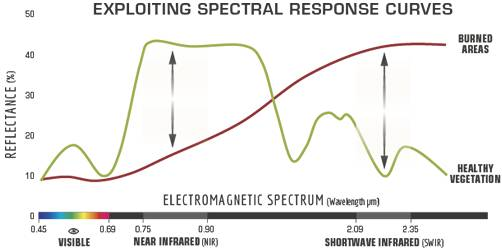  
> Figure 2. Comparison of the spectral response of healthy vegetation and burned areas. Source: U.S. Forest service.
> 
> To benefit from the magnitude of spectral difference, NBR uses the ratio between NIR and SWIR bands, according to the formula shown below. A high NBR value indicates healthy vegetation while a low value indicates bare ground and recently burnt areas. Non-burnt areas are normally attributed to values close to zero.
>
> $NBR = \frac{NIR - SWIR}{NIR + SWIR}$

Source: [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)

Red dots mark the location of the evacuated villages, the background shows the calculated $NBR$ values, where areas with a low $NBR$ value are brighter and areas with a high NBR value are darker.

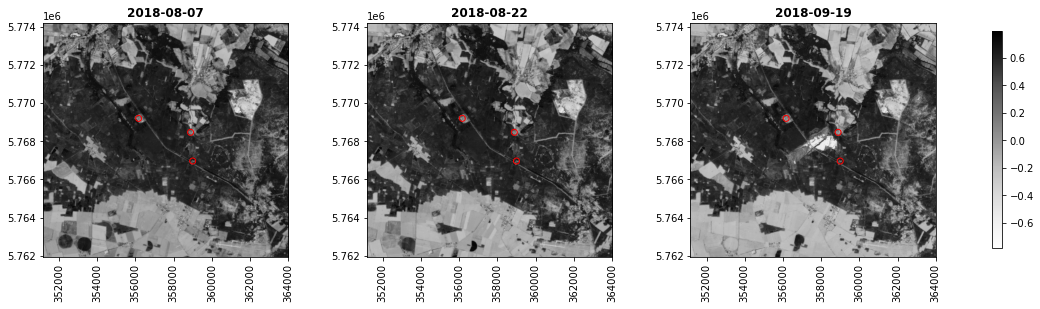

In [6]:
plot_nbrs(potsdam_mittelmark_nbr_2018, potsdam_mittelmark_geom)

### dNBR calculation

In order to calculate ${\Delta}NBR$, the NBR after the fire is sutracted from the NBR before the fire.
Reminder:

$$
{\Delta}NBR = NBR_\text{pre} - NBR_\text{post}
$$

In [7]:
def calculate_dnbr(pre_nbr, post_nbr, geom=[]):
    with RasterReaderList([pre_nbr, post_nbr]) as readers:
        if len(geom):
            # if a geometry is passed, perform all calculations only in the
            # surroundings if this geometry
            _geom = geom.to_crs(readers[0].crs)
            window = geometry_window(readers[0], _geom.buffer(5000))
            window_transform = readers[0].window_transform(window)
        else:
            window = window_transform = None
        
        pre_fire = readers[0].read(masked=True, window=window)
        post_fire = readers[1].read(masked=True, window=window)

        # we need to mask invalid pixels in any of the input files for the resulting file
        dnbr = pre_fire - post_fire
        dnbr.mask = pre_fire.mask | post_fire.mask
        
        return (dnbr, window, window_transform)

changes> dNBR values can vary from case to case, and so, if possible, interpretation in specific instances should also be carried out through field assessment; in order to obtain the best results. However, the United States Geological Survey (USGS) proposed a classification table to interpret the burn severity, which can be seen below (Table 1).
>
> 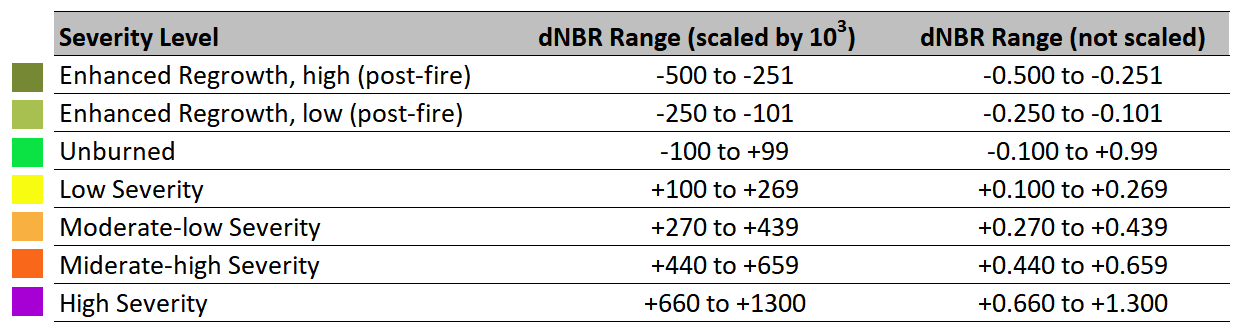
> Table 1. Burn severity levels obtained calculating dNBR, proposed by USGS.

Source: [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio)

We construct a custom color scheme for matplotlib to match the values given in the table above and define a function that helps us plot the $\Delta$NBR values using different color scales:

In [8]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# define discrete color scale based on table above
cmap = ListedColormap(['#778835', '#a7c050', '#0be344', '#f8fc11', '#f8b140', '#f8671a', '#a600d4'])
boundaries = [-0.5, -0.25, -0.1, 0.1, 0.27, 0.44, 0.66, 1.3]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

def plot_dnbr(dnbr, dnbr_crs, dnbr_transform, geom):
    fig, (ax1, ax2) = pplt.subplots(ncols=2, figsize=(20, 8))
    _geom = geom.to_crs(dnbr_crs)

    # plot black and white image
    rplt.show(dnbr, ax=ax1, transform=dnbr_transform, cmap='Greys', vmin=boundaries[0], vmax=boundaries[-1])
    ax1.tick_params(axis='x', labelrotation=90)
    _geom.plot(ax=ax1, facecolor='none', edgecolor='red')
    
    # plot image using colormap from above
    rplt.show(dnbr, ax=ax2, transform=dnbr_transform, cmap=cmap, norm=norm)
    ax2.tick_params(axis='x', labelrotation=90)
    _geom.plot(ax=ax2, facecolor='none', edgecolor='black')
    
    fig.colorbar(ax1.get_images()[0], ax=ax1, shrink=0.2)
    fig.colorbar(ax2.get_images()[0], ax=ax2, shrink=0.2)

Text(0.5, 0.98, 'ΔNBR Potsdam Mittelmark 2018-08-22 / 2018-09-19')

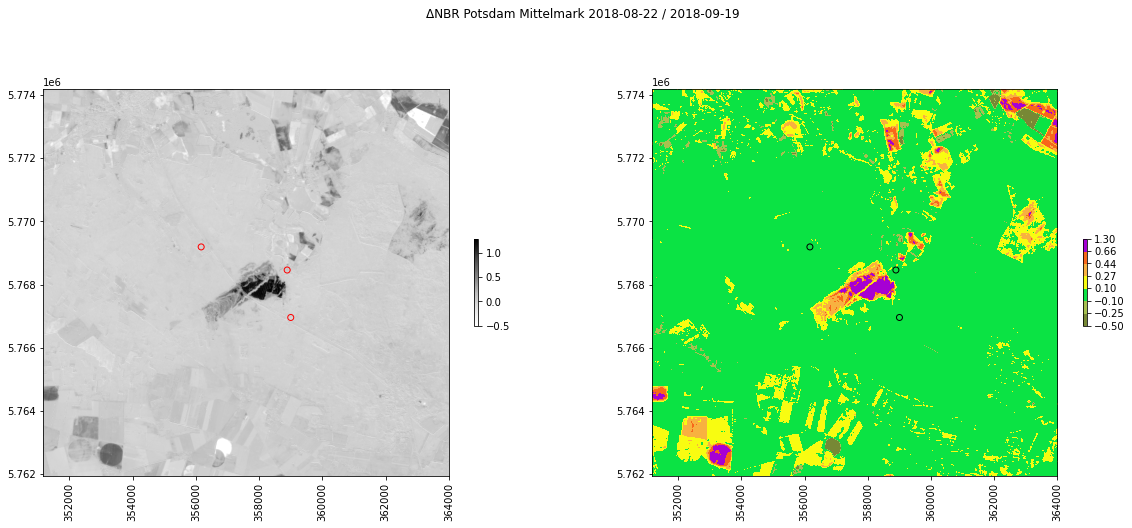

In [9]:
with r.open(potsdam_mittelmark_nbr_2018[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(potsdam_mittelmark_nbr_2018[1], potsdam_mittelmark_nbr_2018[2], potsdam_mittelmark_geom)
plot_dnbr(dnbr, src.crs, window_transform, potsdam_mittelmark_geom)

pre_date = scihub_band_date(potsdam_mittelmark_nbr_2018[1])
post_date = scihub_band_date(potsdam_mittelmark_nbr_2018[2])
pplt.suptitle(f'ΔNBR Potsdam Mittelmark {pre_date.strftime("%Y-%m-%d")} / {post_date.strftime("%Y-%m-%d")}')

The left image shows a dark spot between the three locations marking a decrease in $NBR$ values after the start of the fire on August 23.
is very likely the result of a loss of vegetation due to the fire.
However, we can also see other examples of vegetation loss in the bottom left and top right corner of both plots which, according to the burn severity scale, are classified as "high severity" burns.

Given the regular shape of these vegetation loss, we may assume that they are the result of crop harvests or that they have other causes unrelated to the fire.
This interpretation is **based on assumptions** that need to be verified by experts.

### Comparison with the Waldbrandstatistik

> Die höchste mediale Aufmerksamkeit erreichte der am 13.08.2018 entstandene Waldbrand bei  Treuenbrietzen  (Obf.  Dippmannsdorf).  Ausgelöst  an  mehreren  Zündstellen  und  durch Weltkriegsmunition  sowie  böige  Winde  verstärkt,  erfasste  der  Brand  schnell  über  300  ha Wald. Mehrere Dörfer wurden evakuiert. Der Baumbestand auf der Fläche, zumeist Kiefern, ist fast komplett vernichtet. 

Source: [Waldbrandstatistik 2018, p. 2](https://forst.brandenburg.de/sixcms/media.php/9/wbra2018.pdf)

Please note that the date given in the Waldbrandstatistik is different to the one [given by Deutsche Welle](https://www.dw.com/en/forest-fires-near-berlin-could-burn-for-days/a-45203042).
It is likely to be the result of an uncorrected typing error (August 13 vs. August 23).

**TODO** They correct this themselves later in their report.

We can extract the area between the three evacuated villages and calculate the burned area.
The coordinates for the box used for the extract can be read from this plot that marks its axes using array coordinates:

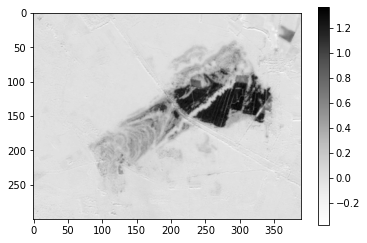

In [11]:
from shapely.geometry import box
from math import floor

potsdam_mittelmark_extract = dnbr[0,500:800,420:810]

img = pplt.imshow(potsdam_mittelmark_extract, cmap='Greys')
pplt.colorbar(img)

We can now calculate all pixels in this extract that are at least a low burn severity.
Each pixel represents an area of 100m².
One ha is 10 000m².
The conversion of numbers of pixels to ha is therefore

$$
\frac{n_\text{pixels} \cdot 100}{10\ 000} = \frac{n_\text{pixels}}{100}
$$

In [13]:
potsdam_mittelmark_burned_area = (potsdam_mittelmark_extract >= 0.1).sum() / 100
potsdam_mittelmark_burned_area

276.74

### Jüterbog 2019

In [14]:
jueterbog_geom = gpd.read_file(product_path / 'jueterbog_2019.json')
jueterbog_nbr_2019 = list(sorted(nbr_path.glob('T33UUT*201906*NBR*.tif')))
jueterbog_nbr_2019

[PosixPath('output/spectral_indices/T33UUT_20190603T101031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20190613T101031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T33UUT_20190626T102031_NBR_10m.tif')]

In [26]:
# geodataframe_on_map(jueterbog_geom)

#### NBR comparison

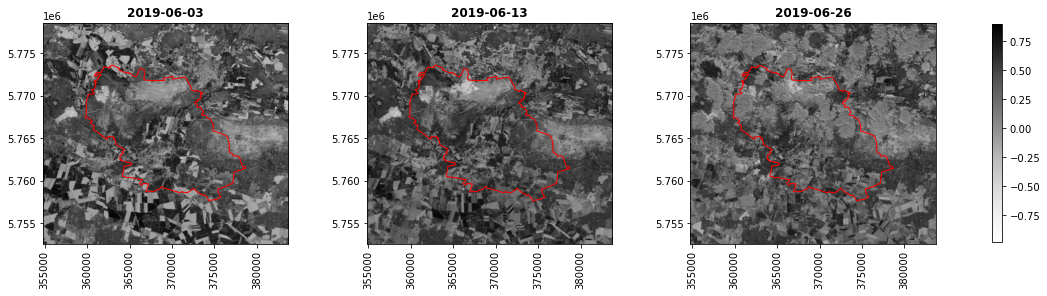

In [16]:
plot_nbrs(jueterbog_nbr_2019, jueterbog_geom)

The plot on the right contains grey spots covering the area, which are clouds that block the view to the ground.
The ${\Delta}NBR$ is calculated using the left and middle images.

#### dNBR calculation

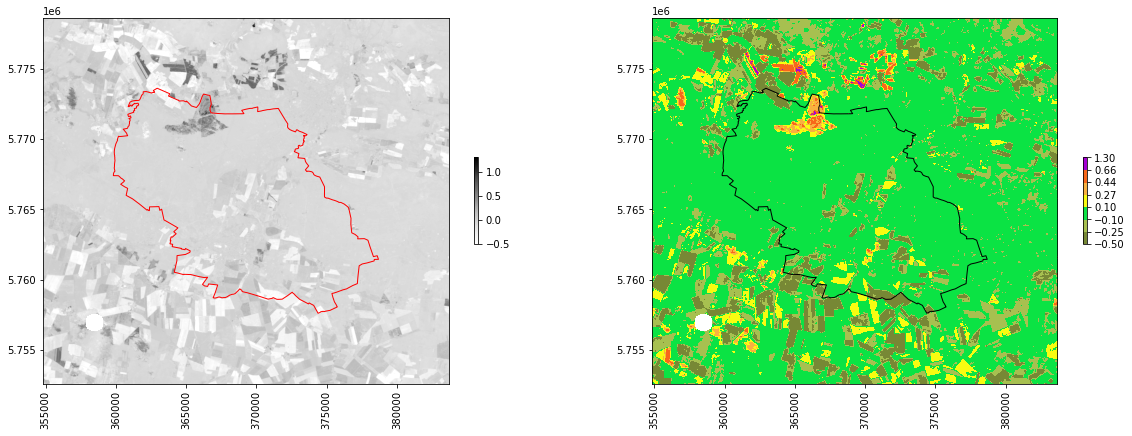

In [25]:
with r.open(jueterbog_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(jueterbog_nbr_2019[0], jueterbog_nbr_2019[1], jueterbog_geom)
plot_dnbr(dnbr, src.crs, window_transform, jueterbog_geom)

Towards the top of the area, many areas show an increase of $NBR$ between the first and second capture date.
Like in Treuenbrietzen, regularly shaped losses indicate non-fire-related value changes.

We try to further restrict the area by searching for the former military site where media reported that the fire broke out:

In [32]:
from sentinel_helpers import search_osm
military_site_geom = search_osm('NSG Forst Zinna-Jüterbog-Keilberg')
# geodataframe_on_map(military_site_geom)

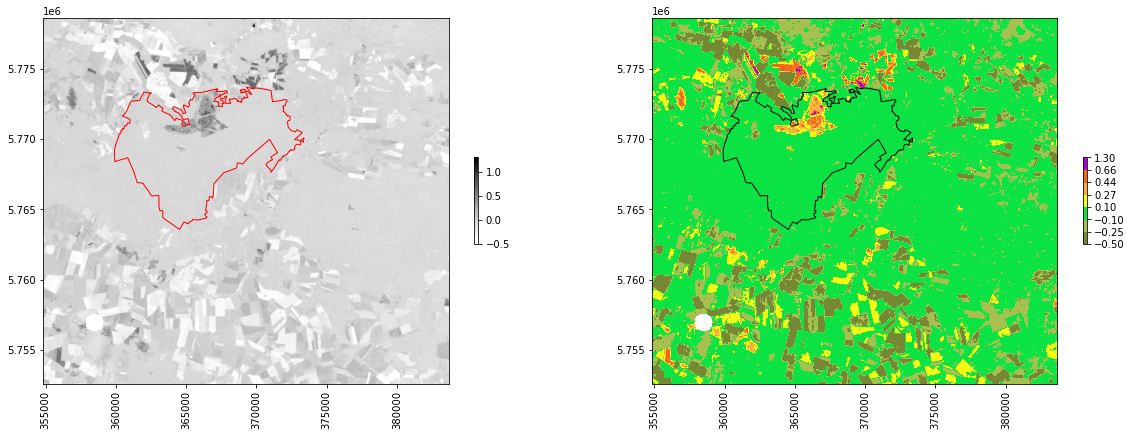

In [31]:
plot_dnbr(dnbr, src.crs, window_transform, military_site_geom)

We can see that the military site encloses an area that is clearly burned.

### Lübtheen

In [18]:
luebtheen_geom = gpd.read_file(product_path / 'luebtheen_2019.json')
luebtheen_nbr_2019 = list(sorted(nbr_path.glob('T32UPE_2019*.tif')))
luebtheen_nbr_2019

[PosixPath('output/spectral_indices/T32UPE_20190629T103031_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T32UPE_20190701T102029_NBR_10m.tif'),
 PosixPath('output/spectral_indices/T32UPE_20190726T102031_NBR_10m.tif')]

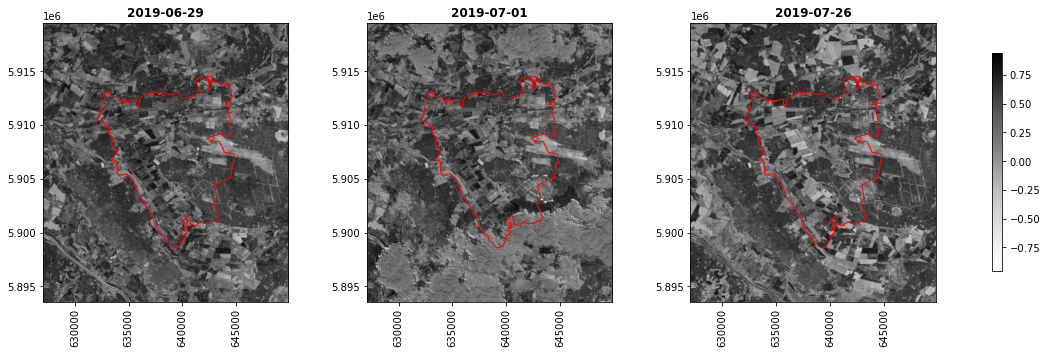

In [19]:
plot_nbrs(luebtheen_nbr_2019, luebtheen_geom)

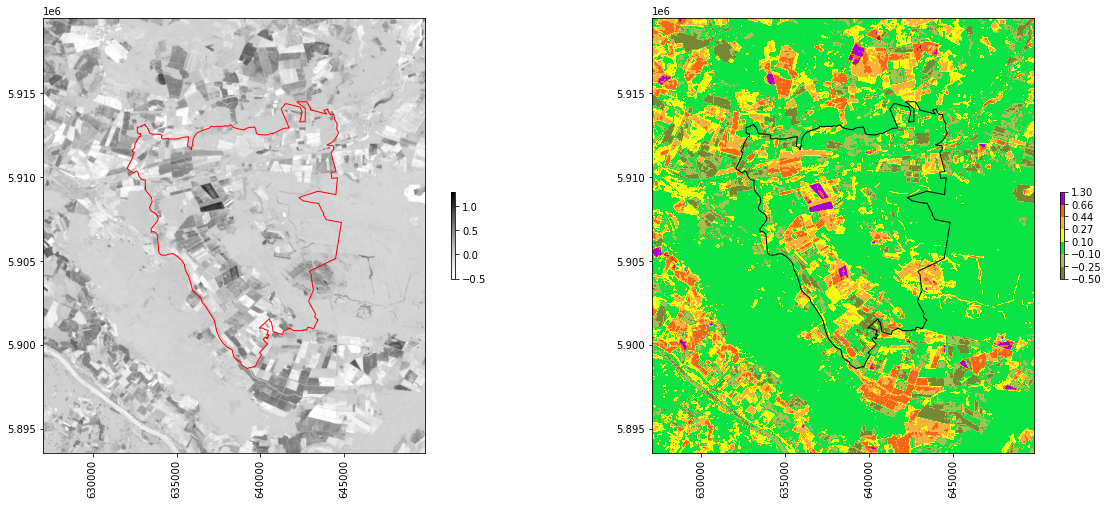

In [20]:
with r.open(luebtheen_nbr_2019[0]) as src:
    # we only need the metadata which is now available in `src`
    pass

dnbr, window, window_transform = calculate_dnbr(luebtheen_nbr_2019[0], luebtheen_nbr_2019[2], luebtheen_geom)
plot_dnbr(dnbr, src.crs, window_transform, luebtheen_geom)

- we do the same with moderate severity

In [21]:
luebtheen_esa_pre_fire = Path('input/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip')
luebtheen_esa_active_fire = Path('input/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip')
luebtheen_esa_post_fire = Path('input/forest_fires/S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_20190726T125507.zip')

In [22]:
from shapely.geometry import box

def preview_true_color(product_zip_path, geometry):
    with r.open(scihub_band_paths(product_zip_path, ['TCI'], '60m')[0]) as src:
        fig, ax = pplt.subplots(figsize=(10,10))
        _geom = geometry.to_crs(src.crs)
        
        window = geometry_window(src, _geom.buffer(5000))
        window_transform = src.window_transform(window)
        
        rplt.show(src.read(window=window), transform=window_transform, ax=ax)
        _geom.plot(ax=ax, facecolor='none', edgecolor='red')

In [23]:
preview_true_color(luebtheen_esa_pre_fire, luebtheen_geom)

FileNotFoundError: [Errno 2] No such file or directory: 'input/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip'

In [ ]:
preview_true_color(luebtheen_esa_active_fire, luebtheen_geom)

- **TODO** Fire is in the bottom right of the red shape

In [ ]:
preview_true_color(luebtheen_esa_post_fire, luebtheen_geom)